In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

get_custom_objects().update({'lrelu': Activation(lrelu)})

In [69]:
# m : batch size
m = 50
# n_z : latent dimension
n_z = 2
# n_epoch : number of epoches for iterations
epochs = 50
epsilon_std=1.0
# intermediate_dim = 512
intermediate_dim = 512
#Original_dim = 784
original_dim = 784


epsilon_std = 1.0

In [70]:
inputs_example = Input(shape=(original_dim,))
h_q = Dense(intermediate_dim, activation='lrelu')(inputs_example)
mu_example = Dense(n_z, activation='linear')(h_q)
log_sigma_example = Dense(n_z, activation='linear')(h_q)

In [71]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(K.shape(mu)[0], n_z), mean=0., stddev=epsilon_std)
    return mu + K.exp(log_sigma / 2) * eps

In [72]:
z = Lambda(sampling, output_shape=(n_z,))([mu_example, log_sigma_example])

In [73]:
# P(X|z) -- decoder
decoder_hidden = Dense(intermediate_dim, activation='relu')
decoder_out = Dense(original_dim, activation='sigmoid')
h_p = decoder_hidden(z)
outputs_example = decoder_out(h_p)

In [74]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, inputs_example, outputs_example):
        xent_loss = original_dim * metrics.binary_crossentropy(inputs_example, outputs_example)
        kl_loss = - 0.5 * K.sum(1 + log_sigma_example - K.square(mu_example) - K.exp(log_sigma_example), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        outputs_example = inputs[1]
        loss = self.vae_loss(x, outputs_example)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [1]:
class CustomVariationalLayer_DEEP(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

NameError: name 'Layer' is not defined

In [75]:
y = CustomVariationalLayer()([inputs_example, outputs_example])
vae = Model(inputs_example, y)
vae.compile(optimizer='rmsprop', loss=None)

C:\Users\wenbi\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_5" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [84]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 16s - loss: 148.9167 - val_loss: 151.7499
Epoch 2/50
60000/60000 [==============================] - 19s - loss: 149.1307 - val_loss: 154.0625
Epoch 3/50
60000/60000 [==============================] - 19s - loss: 149.5824 - val_loss: 154.5000
Epoch 4/50
60000/60000 [==============================] - 18s - loss: 150.4904 - val_loss: 158.7999
Epoch 5/50
60000/60000 [==============================] - 18s - loss: 151.6998 - val_loss: 156.0353
Epoch 6/50
60000/60000 [==============================] - 19s - loss: 152.2487 - val_loss: 160.3334
Epoch 7/50
60000/60000 [==============================] - 17s - loss: 153.4521 - val_loss: 166.3458
Epoch 8/50
60000/60000 [==============================] - 20s - loss: 154.6730 - val_loss: 153.7466
Epoch 9/50
60000/60000 [==============================] - 18s - loss: 154.9951 - val_loss: 157.3880
Epoch 10/50
60000/60000 [=========================

In [78]:
encoder = Model(inputs_example, mu_example)

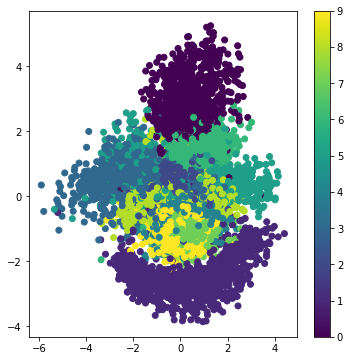

In [79]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [81]:
decoder_input = Input(shape=(n_z,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator_example = Model(decoder_input, _x_decoded_mean)

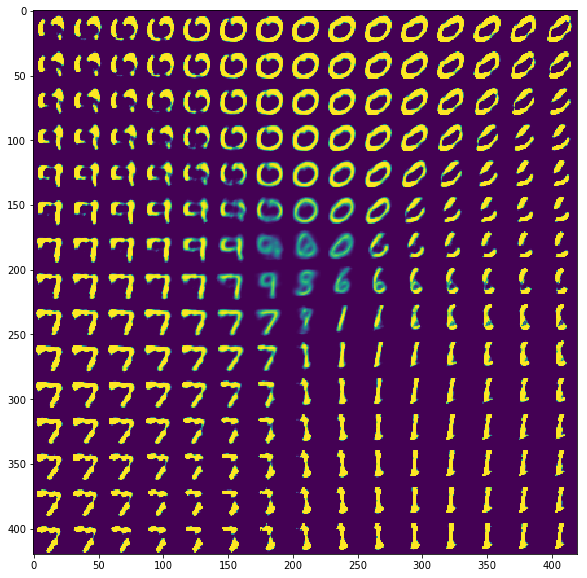

In [83]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 2.0
        x_decoded = generator_example.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [56]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [57]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

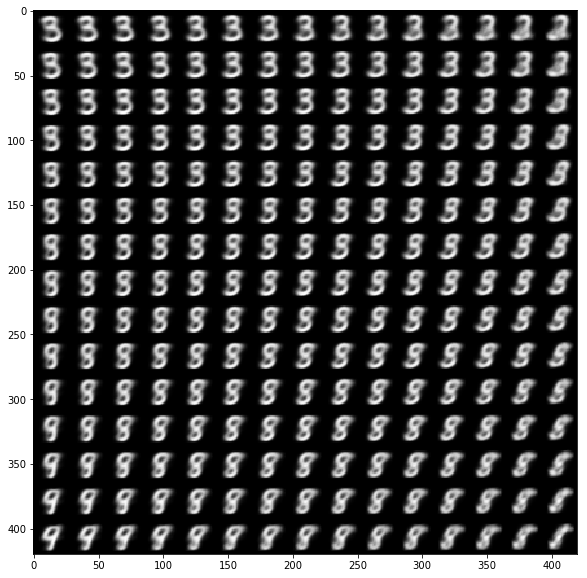

In [59]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()